In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torchvision import models
from torchvision import transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import random_split, DataLoader

def transform_arr(arr:np.ndarray, in_pose=True, in_rh=True, in_lh=True, resize_length = None, expand_dims=False):
    lh = arr[:, :21*2]
    rh = arr[:, 21*2: 21*2 + 21*2]
    pose = arr[:, 21*2 + 21*2 : 21*2 + 21*2 + 25*2]

    sequence = []
    if in_pose:
        sequence.append(pose)
    if in_rh:
        sequence.append(rh)
        
    if in_lh:
        sequence.append(lh)

    
    sequence = np.concatenate(sequence, axis=1)

    if resize_length:
        sequence = myresize(sequence, resize_length)
    if expand_dims:
        sequence = np.expand_dims(sequence, axis=0)
    sequence = sequence.astype(np.float32)
    return sequence

def myresize(src, target_length, ):
    src = src.copy()
    src.resize(target_length,  134)
    return  src

def count_streak(lst):
    if torch.is_tensor(lst):
        lst = lst.tolist()
    result = []
    current_streak = None
    current_count = 0
    for item in lst:
        if item != current_streak:
            if current_streak is not None:
                result.append((current_streak, current_count))
            current_streak = item
            current_count = 1
        else:
            current_count += 1
    result.append((current_streak, current_count))
    result = sorted(result, key=lambda x: x[1], reverse=True)
    return result

In [4]:
torch.manual_seed(42)
root_dir = "npy/datase/which/is/the/destination/path/of/fill/None/using/LinearRegression/module"

data_transforms = transforms.Compose([
    transforms.Lambda(lambda x:transform_arr(x)),
])

dataset = DatasetFolder(root_dir, np.load, ['.npy'], transform=data_transforms) # , transform=Lambda(lambda arr: myresize(arr, mode).astype(np.float32) ))
train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15])

batch_size = 1
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # , num_workers=8)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True) # , num_workers=8)

In [5]:
next(iter(trainloader))[0].shape

torch.Size([1, 61, 134])

In [6]:
class MyModel(nn.Module):
    def __init__(self, *args,device = 'cpu'):
        super(MyModel, self).__init__()
        self._device = device
        self.num_layers = len(args)-1
        self.headen_states = []
        for i in range(1, len(args)):
            # self.headen_states.append([*torch.zeros(2, 1, 1, args[i], device=self._device)])
            self.headen_states.append(torch.zeros(1, 1, args[i], device=self._device))
            self.add_module(f"gru{i}", nn.GRU(args[i-1], args[i], batch_first=True, device=self._device))
            # self.add_module(f"linear{i}", nn.Linear(args[i], args[i], device=self._device))
            # self.add_module(f"relu{i}", nn.ReLU())
        

    def forward(self, x):
        for i, module in enumerate(self.children()):
            # self.headen_states[i] = self.headen_states[i].detach()
            # self.headen_states[i][1] = self.headen_states[i][1].detach()
            
            # if isinstance(module, nn.GRU):
            #     x, self.headen_states[i//3] =  module(x, self.headen_states[i//3])
            # elif i != 8:
            #     x = module(x)
            x, self.headen_states[i] =  module(x, self.headen_states[i])
            
            # print(module)
            # x, self.headen_states[i] =  module(x, self.headen_states[i])
            # self.headen_states[i] = list(headen_state)
            # self.headen_states[i] = headen_state
        return x
    
    def on_epoch(self):
        for i in range(self.num_layers):
            self.headen_states[i] = torch.zeros_like(self.headen_states[i])
    
    def on_batch(self):
        for i in range(self.num_layers):
            self.headen_states[i] = self.headen_states[i].detach()
    
    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, value):
        print("Set the device")
        self = self.to(value)
        i=0
        while i< self.num_layers:
            self.headen_states[i][0] = self.headen_states[i][0].to(value)
            self.headen_states[i][1] = self.headen_states[i][1].to(value)
            i+=1

In [7]:
device = 'cuda'
model = MyModel(134, 64, 32, 20, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [14]:
num_epochs = 1000
patience = 5

loss_counter, dif_counter, acc_counter = 0, 0, 0

train_accs = []
valid_accs = []

train_losses = []
valid_losses = []
min_loss, min_diff, max_valid_acc, max_train_acc =1e100, 1.5, 0, 0

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Initialize progress bar
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", position=0)

    # Initialize variables for computing accuracy
    total_train_samples = 0
    total_train_correct = 0
    total_train_loss = 0

    successes = []

    # Iterate over batches
    model.on_epoch()
    for batch_idx, (data, targets) in enumerate(progress_bar):
        # Move input and label tensors to the GPU
        data, targets = data.to(device), targets.to(device)

        model.on_batch()
        # Forward pass
        # log_ps = model(data)
        logits = model(data)
        
        b, s, f = logits.shape
        logits = logits.view(b*s, f)
        targets = targets.repeat(b*s)
        
        loss = criterion(logits, targets)
        
        predictions = torch.softmax(logits, dim=1).argmax(dim=1)
        cs = count_streak(predictions)
        max_streak = cs[0][1]
        streak_weight = (max_streak/predictions.shape[0])*((-1) ** (cs[0][0] == targets[0]))
        loss *= (1+streak_weight)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute number of correct predictions and total samples
        predictions = torch.softmax(logits, dim=1).argmax(dim=1)
        total_train_samples += targets.size(0)
        total_train_correct += (predictions == targets).sum().item()
        total_train_loss+=loss.item()

        train_loss = total_train_loss / total_train_samples
        train_acc = 100*total_train_correct / total_train_samples

        if cs[0][0] == targets[0]:
            successes.append(1)
        else:
            successes.append(0)
        
        # Update progress bar
        progress_bar.set_postfix(train_loss=train_loss, train_acc=train_acc, successes=np.mean(successes)*100)
        
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Evaluate on validation set
    with torch.no_grad():
        # Set model to evaluation mode
        model.eval()

        # Initialize progress bar
        progress_bar = tqdm(validloader, desc=f"Validation")

        # Initialize variables for computing accuracy
        total_valid_samples = 0
        total_valid_correct = 0
        total_valid_loss = 0

        successes = []

        # Iterate over batches
        for data, targets in progress_bar:
            # Move input and label tensors to the GPU
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            # log_ps = model(data)
            logits = model(data)

            b, s, f = logits.shape
            logits = logits.view(b*s, f)
            targets = targets.repeat(b*s)

            loss = criterion(logits, targets)

            predictions = torch.softmax(logits, dim=1).argmax(dim=1)
            cs = count_streak(predictions)
            max_streak = cs[0][1]
            streak_weight = (max_streak/predictions.shape[0])*((-1) ** (cs[0][0] == targets[0]))
            loss *= (1+streak_weight)

            # Compute number of correct predictions and total samples
            # predictions = torch.exp(logits).argmax(dim=1)
            predictions = torch.softmax(logits, dim=1).argmax(dim=1)
            total_valid_samples += targets.size(0)
            total_valid_correct += (predictions == targets).sum().item()
            total_valid_loss+=loss.item()

            valid_loss = total_valid_loss / total_valid_samples
            valid_acc = 100*total_valid_correct / total_valid_samples

            if cs[0][0] == targets[0]:
                successes.append(1)
            else:
                successes.append(0)            

            # Update progress bar
            progress_bar.set_postfix(valid_loss=valid_loss, valid_acc=valid_acc, successes=np.mean(successes)*100)
    
        valid_accs.append(valid_acc)
        valid_losses.append(valid_loss)

    # if valid_loss >= min_loss:
    #     loss_counter+=1
    # else:
    #     loss_counter = 0
    #     min_loss = valid_loss
    #     torch.save(model.state_dict(), f"callback_checkpoint_minLoss.pth")

    # if valid_acc < max_valid_acc and diff > 0:
    #     acc_counter+=1
    # else:
    #     acc_counter = 0
    #     max_valid_acc = valid_acc
    #     torch.save(model.state_dict(), f"callback_checkpoint_v2.pth")
    
    # diff = train_acc - valid_acc
    # if diff > 1.5:
    #     dif_counter+=1
    # else:
    #     dif_counter = 0
    #     if diff < min_diff:
    #         min_diff = diff
    #         torch.save(model.state_dict(), f"callback_checkpoint_minDiff.pth")
    
    diff = train_acc - valid_acc
    if diff > 1.5:
        dif_counter+=1
    else:
        dif_counter = 0
        if valid_loss < min_loss:
            min_loss = valid_loss
            loss_counter=0
            torch.save(model.state_dict(), f"callback_checkpoint_minLossWithin1.5Diff.pth")
        else:
            loss_counter+=1
    
    if patience in [dif_counter, loss_counter]:
        break

    break

Epoch 1/1000:   0%|          | 0/5906 [00:00<?, ?it/s]

Validation: 100%|██████████| 1266/1266 [00:28<00:00, 43.89it/s, successes=91, valid_acc=73.5, valid_loss=0.00901]  


In [9]:
from winsound import Beep
Beep(1000, 1000)

In [12]:
from copy import deepcopy

class MyModel(nn.Module):
    def __init__(self, *args,device = 'cpu'):
        super(MyModel, self).__init__()
        self._device = device
        self.num_layers = len(args)-1
        self.headen_states = []
        for i in range(1, len(args)):
            # self.headen_states.append([*torch.zeros(2, 1, 1, args[i], device=self._device)])
            self.headen_states.append(torch.zeros(1, 1, args[i], device=self._device))
            self.add_module(f"gru{i}", nn.GRU(args[i-1], args[i], batch_first=True, device=self._device))
            self.add_module(f"linear{i}", nn.Linear(args[i], args[i], device=self._device))
            self.add_module(f"relu{i}", nn.ReLU())
        

    def forward(self, x):
        for i, module in enumerate(self.children()):
            # self.headen_states[i] = self.headen_states[i].detach()
            # self.headen_states[i][1] = self.headen_states[i][1].detach()
            
            if isinstance(module, nn.GRU):
                x, self.headen_states[i//3] =  module(x, self.headen_states[i//3])
            elif i != 8:
                x = module(x)
            # x, self.headen_states[i] =  module(x, self.headen_states[i])
            
            # print(module)
            # x, self.headen_states[i] =  module(x, self.headen_states[i])
            # self.headen_states[i] = list(headen_state)
            # self.headen_states[i] = headen_state
        return x
    
    def on_epoch(self):
        for i in range(self.num_layers):
            self.headen_states[i] = torch.zeros_like(self.headen_states[i])
    
    def on_batch(self):
        for i in range(self.num_layers):
            self.headen_states[i] = self.headen_states[i].detach()
    
    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, value):
        print("Set the device")
        self = self.to(value)
        i=0
        while i< self.num_layers:
            self.headen_states[i][0] = self.headen_states[i][0].to(value)
            self.headen_states[i][1] = self.headen_states[i][1].to(value)
            i+=1

device = 'cuda'
evaluate_model = MyModel(134, 64, 32, 20, device=device)

# evaluate_model = deepcopy(model)

state_dict = torch.load("[realtime-linearReLu-cost=97.7]callback_checkpoint_minLossWithin1.5Diff.pth")
evaluate_model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
def count_streak(lst):
    if torch.is_tensor(lst):
        lst = lst.tolist()
    result = []
    current_streak = None
    current_count = 0
    for item in lst:
        if item != current_streak:
            if current_streak is not None:
                result.append((current_streak, current_count))
            current_streak = item
            current_count = 1
        else:
            current_count += 1
    result.append((current_streak, current_count))
    result = sorted(result, key=lambda x: x[1], reverse=True)
    return result

with torch.no_grad():
    # Set model to evaluation mode
    evaluate_model.eval()

    # Initialize progress bar
    # progress_bar = tqdm(testloader, desc=f"Validation")
    progress_bar = tqdm(trainloader, desc=f"Validation")

    # Initialize variables for computing accuracy
    total_valid_samples = 0
    total_valid_correct = 0
    total_valid_loss = 0

    y_test_pred = []
    y_test = []
    logits_test = []


    success_rate = 0
    max_count_streaks = []
    secondmax_count_streaks = []
    success = []

    # Iterate over batches
    for data, targets in progress_bar:
        # Move input and label tensors to the GPU
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        logits = evaluate_model(data)

        b, s, f = logits.shape
        logits = logits.view(b*s, f)
        targets = targets.repeat(b*s)

        loss = criterion(logits, targets)
        
        predictions = torch.softmax(logits, dim=1).argmax(dim=1)
        cs = count_streak(predictions)
        max_streak = cs[0][1]
        streak_weight = (max_streak/predictions.shape[0])*((-1) ** cs[0][0] == targets[0])
        loss *= (1+streak_weight)

        # Compute number of correct predictions and total samples
        # predictions = torch.exp(ps).argmax(dim=1)
        predictions = torch.softmax(logits, dim=1).argmax(dim=1)
        total_valid_samples += targets.size(0)
        total_valid_correct += (predictions == targets).sum().item()
        total_valid_loss+=loss.item()

        valid_loss = total_valid_loss / total_valid_samples
        valid_acc = 100*total_valid_correct / total_valid_samples


        # Update progress bar
        progress_bar.set_postfix(valid_loss=valid_loss, valid_acc=valid_acc)

        # print(f"predictions:{predictions}\n targets:{targets}")
        # break
        cs = count_streak(predictions)
        # print(cs)
        max_count_streaks.append(cs[0][1])
        try:
            secondmax_count_streaks.append(cs[1][1])
        except IndexError:
            secondmax_count_streaks.append(0)

        if cs[0][0] == targets[0]:
            success_rate+=1
            success.append(1)
        else:
            success.append(0)

        y_test_pred.append(cs[0][0])
        y_test.append(targets[0].item())
        logits_test.append(logits)

        # if predictions.mode().values == targets[0]:
        #     success_rate+=1
        #     success.append(1)
        # else:
        #     success.append(0)
    # y_test_pred = torch.concatenate(y_test_pred)
    # y_test = torch.concatenate(y_test)
    # logits_test = torch.concatenate(logits_test)
# torch.softmax(logits, dim=1).max(dim=1)
# f"{(predictions != targets).type(torch.float32).sum()} / {len(targets)}", f"count_streak: {count_streak(predictions)}"
np.mean(success)

Validation: 100%|██████████| 5906/5906 [03:27<00:00, 28.40it/s, valid_acc=81.9, valid_loss=0.00868]


0.9917033525228581

In [16]:
# Validation: 100%|██████████| 5906/5906 [01:25<00:00, 69.17it/s, valid_acc=82, valid_loss=0.00832]
# 0.9842533017270573

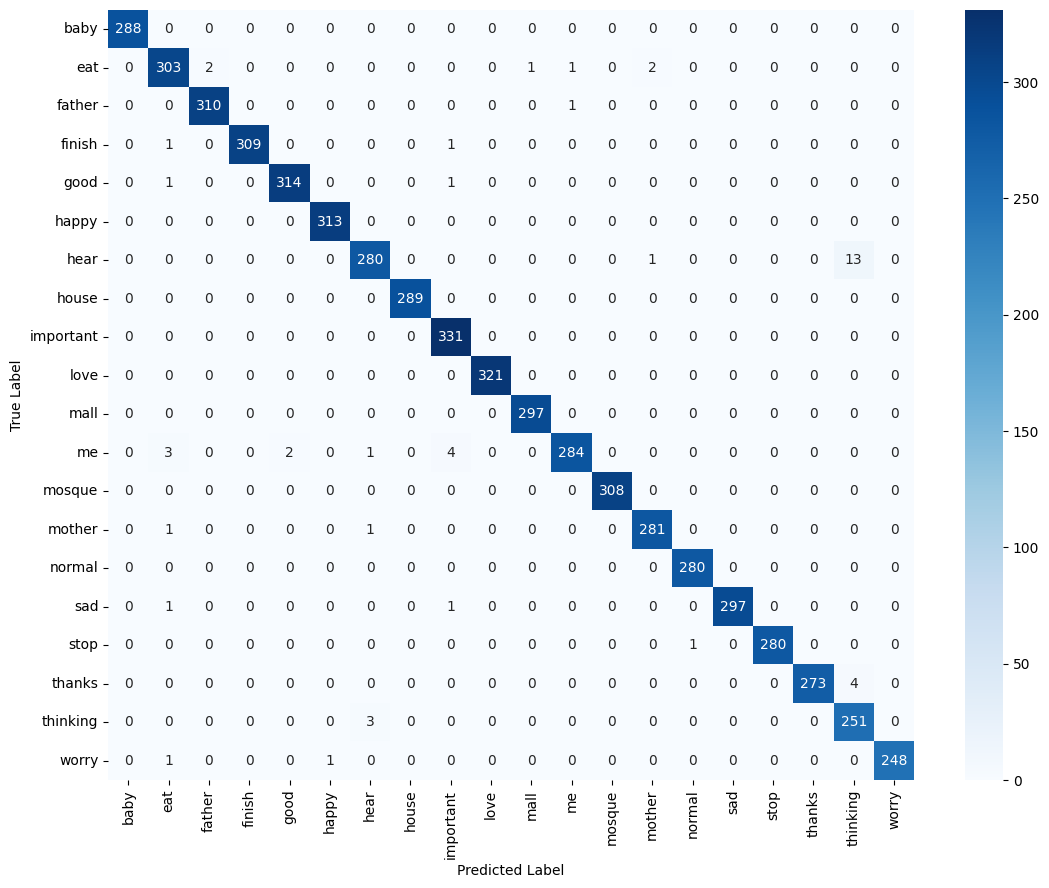

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_test_pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=1)


plt.figure(figsize=(13, 10))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label');
plt.savefig('phase_1_deap_learning_Test_Confusion_Matrix.jpg', bbox_inches='tight');

In [20]:
700*15

10500

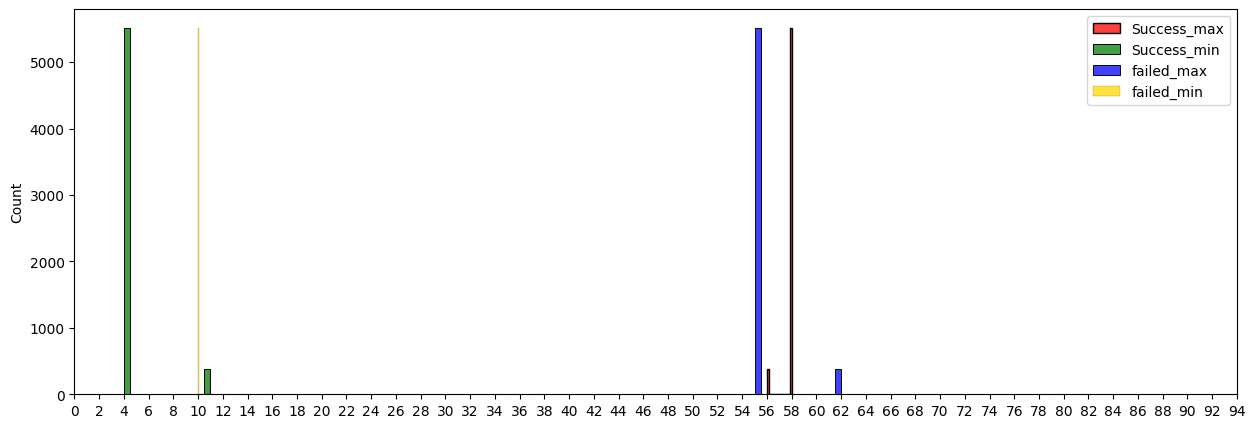

In [17]:
# trash
data = np.concatenate([np.array(max_count_streaks).reshape(-1, 1), np.array(secondmax_count_streaks).reshape(-1, 1), np.array(success).reshape(-1, 1)], axis=1)
data.shape

plt.figure(figsize=(15, 5))

sns.histplot(x=data[np.array(success), 0], color='red', label='Success_max')
sns.histplot(x=data[np.array(success), 1], color='g', label='Success_min')

sns.histplot(x=data[~np.array(success), 0], color='blue', label='failed_max')
sns.histplot(x=data[~np.array(success), 1], color='gold', label='failed_min')
plt.xticks(range(0, 95, 2))
plt.legend();

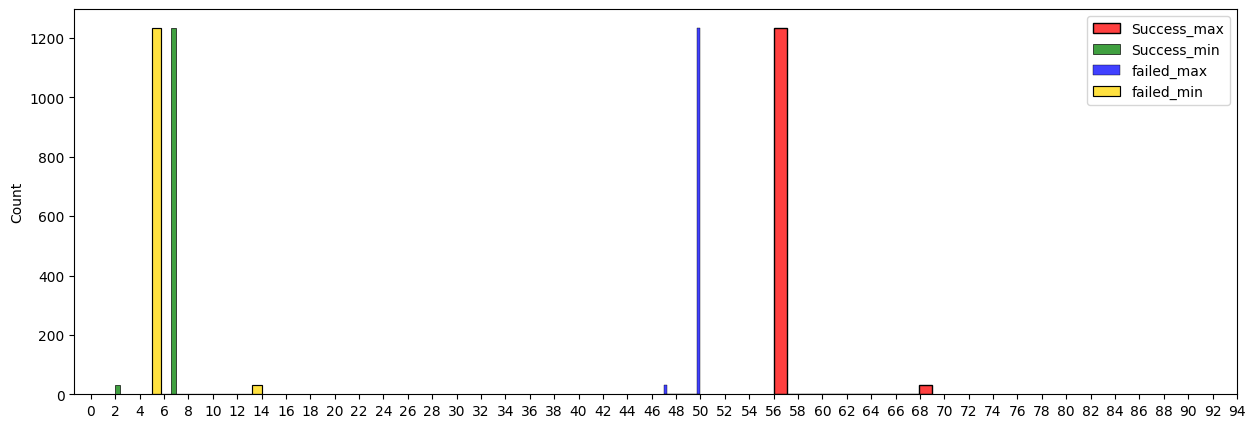

In [71]:
# lstm
data = np.concatenate([np.array(max_count_streaks).reshape(-1, 1), np.array(secondmax_count_streaks).reshape(-1, 1), np.array(success).reshape(-1, 1)], axis=1)
data.shape

plt.figure(figsize=(15, 5))

sns.histplot(x=data[np.array(success), 0], color='red', label='Success_max')
sns.histplot(x=data[np.array(success), 1], color='g', label='Success_min')

sns.histplot(x=data[~np.array(success), 0], color='blue', label='failed_max')
sns.histplot(x=data[~np.array(success), 1], color='gold', label='failed_min')
plt.xticks(range(0, 95, 2))
plt.legend();

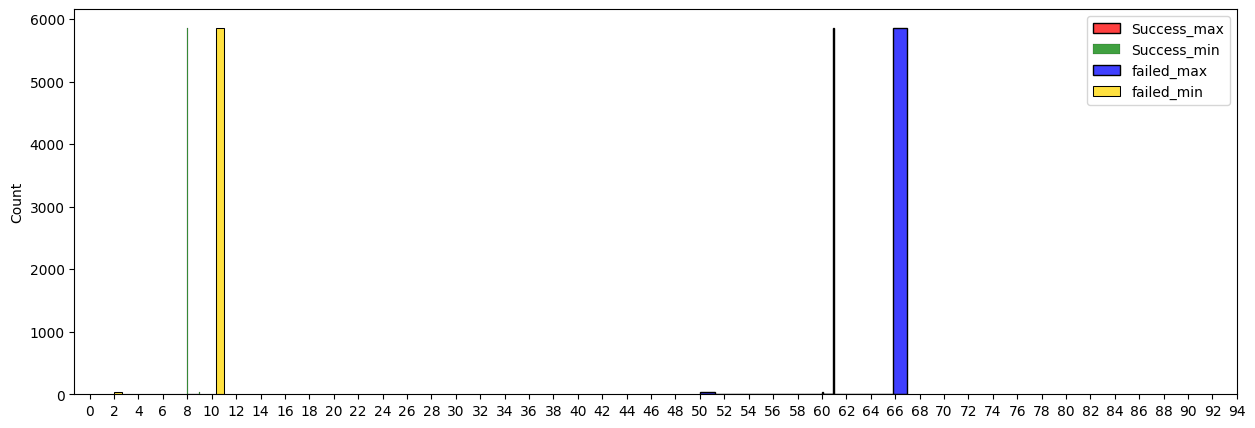

In [68]:
# lstm
data = np.concatenate([np.array(max_count_streaks).reshape(-1, 1), np.array(secondmax_count_streaks).reshape(-1, 1), np.array(success).reshape(-1, 1)], axis=1)
data.shape

plt.figure(figsize=(15, 5))

sns.histplot(x=data[np.array(success), 0], color='red', label='Success_max')
sns.histplot(x=data[np.array(success), 1], color='g', label='Success_min')

sns.histplot(x=data[~np.array(success), 0], color='blue', label='failed_max')
sns.histplot(x=data[~np.array(success), 1], color='gold', label='failed_min')
plt.xticks(range(0, 95, 2))
plt.legend();

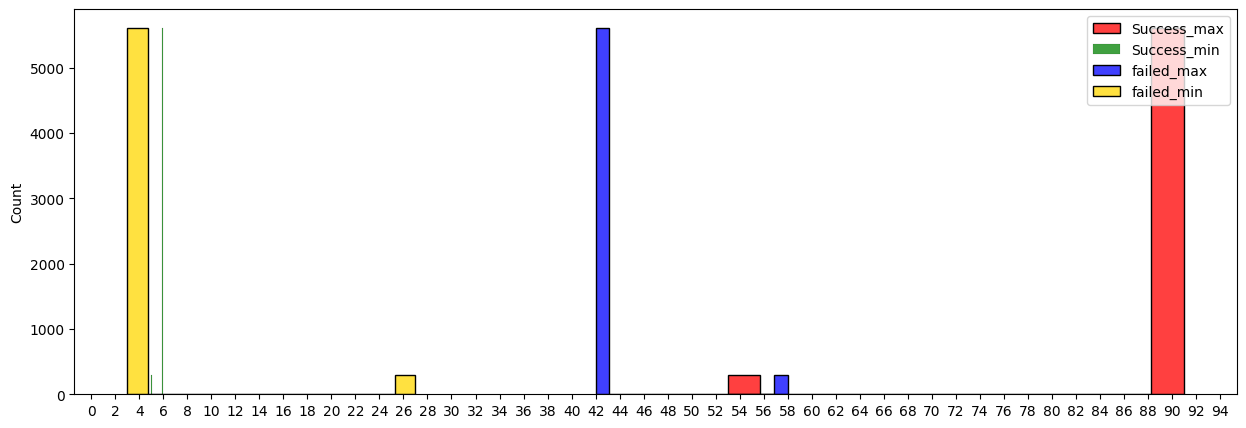

In [47]:
# lstm
data = np.concatenate([np.array(max_count_streaks).reshape(-1, 1), np.array(secondmax_count_streaks).reshape(-1, 1), np.array(success).reshape(-1, 1)], axis=1)
data.shape

plt.figure(figsize=(15, 5))

sns.histplot(x=data[np.array(success), 0], color='red', label='Success_max')
sns.histplot(x=data[np.array(success), 1], color='g', label='Success_min')

sns.histplot(x=data[~np.array(success), 0], color='blue', label='failed_max')
sns.histplot(x=data[~np.array(success), 1], color='gold', label='failed_min')
plt.xticks(range(0, 95, 2))
plt.legend();

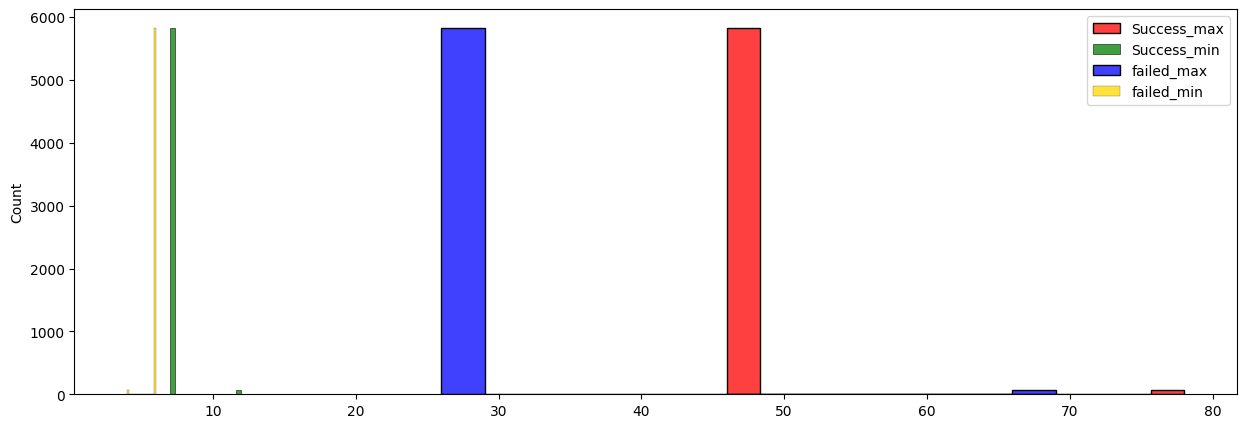

In [35]:
# linear
data = np.concatenate([np.array(max_count_streaks).reshape(-1, 1), np.array(secondmax_count_streaks).reshape(-1, 1), np.array(success).reshape(-1, 1)], axis=1)
data.shape

plt.figure(figsize=(15, 5))

sns.histplot(x=data[np.array(success), 0], color='red', label='Success_max')
sns.histplot(x=data[np.array(success), 1], color='g', label='Success_min')

sns.histplot(x=data[~np.array(success), 0], color='blue', label='failed_max')
sns.histplot(x=data[~np.array(success), 1], color='gold', label='failed_min')
plt.xticks(range(0, 95, 2))

plt.legend();

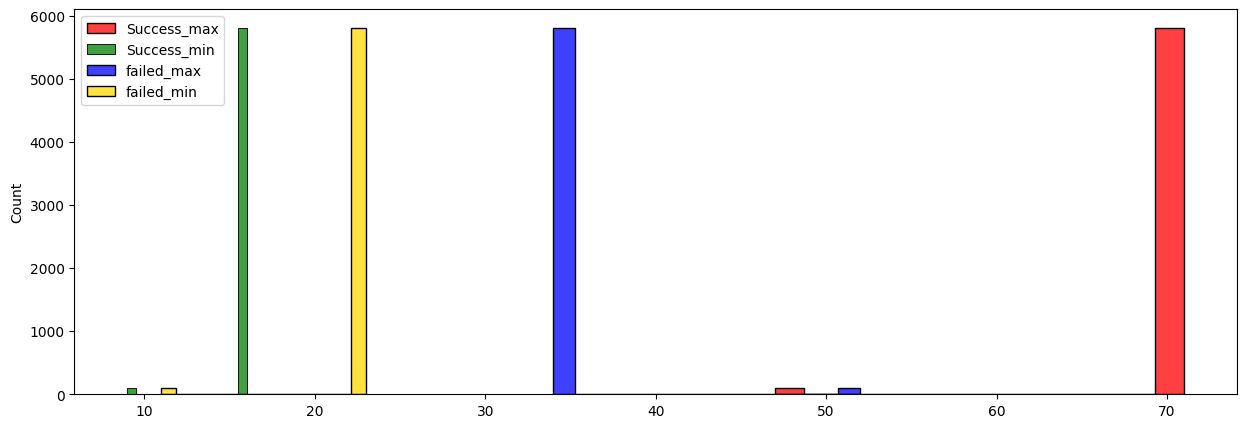

In [24]:
# linear with relu
data = np.concatenate([np.array(max_count_streaks).reshape(-1, 1), np.array(secondmax_count_streaks).reshape(-1, 1), np.array(success).reshape(-1, 1)], axis=1)
data.shape

plt.figure(figsize=(15, 5))

sns.histplot(x=data[np.array(success), 0], color='red', label='Success_max')
sns.histplot(x=data[np.array(success), 1], color='g', label='Success_min')

sns.histplot(x=data[~np.array(success), 0], color='blue', label='failed_max')
sns.histplot(x=data[~np.array(success), 1], color='gold', label='failed_min')
plt.xticks(range(0, 95, 2))
plt.legend();

In [103]:
import mediapipe as mp
from glob import glob

BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode

HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions

PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
pose_model_path = '../mediapipe_models/pose_landmarker_heavy.task'
hand_model_path = '../mediapipe_models/hand_landmarker.task'

pose_options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=pose_model_path),
    running_mode=VisionRunningMode.VIDEO)

# Create a hand landmarker instance with the image mode:
hand_options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=hand_model_path),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=2)

def mediapipe_detection(numpy_image, frame_timestamp_ms, poselandmarker, handlandmarker): # we assume that input image is in BGR format

    numpy_image = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)
    numpy_image = cv2.flip(numpy_image, 1)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_image)

    pose_landmarker_result = poselandmarker.detect_for_video(mp_image, frame_timestamp_ms)
    hand_landmarker_result = handlandmarker.detect_for_video(mp_image, frame_timestamp_ms)

    return pose_landmarker_result, hand_landmarker_result

def extract_keypoints(pose_landmarker_result, hand_landmarker_result):
    
    bodies = pose_landmarker_result.pose_world_landmarks
    body_npy = np.zeros(33*2)
    i=0
    for body in bodies:
        for landmark in body:
            body_npy[i:i+2] = [landmark.x, landmark.y]
            i+=2

    body_npy = body_npy[:25*2]

    hands = hand_landmarker_result.hand_world_landmarks
    hands_npy = np.zeros(21*2*2)
    i=0
    for hand in hands:
        for landmark in hand:
            hands_npy[i:i+2] = [landmark.x, landmark.y]
            i+=2

    landmarks = np.concatenate([body_npy, hands_npy], axis=0)
    return landmarks


def frame2npy(image, frame_timestamp_ms, poselandmarker, handlandmarker):
    pose_results, hands_results = mediapipe_detection(image, frame_timestamp_ms, poselandmarker, handlandmarker)
    landmarks = extract_keypoints(pose_results, hands_results)
    return landmarks

evaluate_model = deepcopy(model)

state_dict = torch.load("callback_checkpoint_minLossWithin1.5Diff.pth")
evaluate_model.load_state_dict(state_dict)

evaluate_model.eval()
video_paths = glob(r"C:\Users\Mahmoud\Pictures\Camera Roll\New folder (4)\video\*\*.mp4")
for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)
    video_npy_ls = []
    with PoseLandmarker.create_from_options(pose_options) as poselandmarker:
        with HandLandmarker.create_from_options(hand_options) as handlandmarker:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame_timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
                frame_npy = frame2npy(frame, frame_timestamp_ms, poselandmarker, handlandmarker)
                video_npy_ls.append(frame_npy)

                frame_npy_tensor = torch.from_numpy(frame_npy)
                frame_npy_tensor = torch.unsqueeze(frame_npy_tensor, dim=0)
                frame_npy_tensor = torch.unsqueeze(frame_npy_tensor, dim=0)
                # print(frame_npy_tensor.shape)
                frame_npy_tensor = frame_npy_tensor.to(device)
                frame_npy_tensor = frame_npy_tensor.to(torch.float32)
                logits = evaluate_model(frame_npy_tensor)
                # print(f"logits.shape: {logits.shape}")
                # print(f"logits: {logits}")
                
                b, s, f = logits.shape
                logits = logits.view(b*s, f)

                predictions = torch.softmax(logits, dim=1).argmax(dim=1)
                print(f"{os.path.basename(video_path)}: {dataset.classes[predictions]}")
                
            cap.release()
    

eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: father
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: me
eat_000.mp4: me
eat_000.mp4: me
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
eat_000.mp4: eat
ea

In [92]:
[[[-7.1570, -6.8152, -7.8678, -7.6130, -7.3580, -7.3257, -7.4276,
          -6.6861, -7.1256, -7.2493, -7.3879, -7.4814, -8.2313, -7.8333,
          -8.4044, -8.0330, -7.5676, -7.4316, -7.6060, -7.9229]]]

['baby',
 'eat',
 'father',
 'finish',
 'good',
 'happy',
 'hear',
 'house',
 'important',
 'love',
 'mall',
 'me',
 'mosque',
 'mother',
 'normal',
 'sad',
 'stop',
 'thanks',
 'thinking',
 'worry']

In [ ]:
torch.from_numpy

['C:\\Users\\Mahmoud\\Pictures\\Camera Roll\\New folder (3)\\video\\baby\\baby.mp4',
 'C:\\Users\\Mahmoud\\Pictures\\Camera Roll\\New folder (3)\\video\\eat\\eat.mp4',
 'C:\\Users\\Mahmoud\\Pictures\\Camera Roll\\New folder (3)\\video\\father\\father.mp4',
 'C:\\Users\\Mahmoud\\Pictures\\Camera Roll\\New folder (3)\\video\\finish\\finish.mp4',
 'C:\\Users\\Mahmoud\\Pictures\\Camera Roll\\New folder (3)\\video\\good\\baby_000.mp4',
 'C:\\Users\\Mahmoud\\Pictures\\Camera Roll\\New folder (3)\\video\\good\\good.mp4']